
## Model Evaluation & Validation
## Project: Predicting Boston Housing Prices




In this project, we will evaluate the performance and predictive power of a model that has been trained and tested on data collected from homes in suburbs of Boston, Massachusetts. A model trained on this data that is seen as a *good fit* could then be used to make certain predictions about a home — in particular, its monetary value. This model would prove to be invaluable for someone like a real estate agent who could make use of such information on a daily basis.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Housing). The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. For the purposes of this project, the following preprocessing steps have been made to the dataset:
- 16 data points have an `'MEDV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- The features `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` are essential. The remaining **non-relevant features** have been excluded.
- The feature `'MEDV'` has been **multiplicatively scaled** to account for 35 years of market inflation.


In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Success
print("Boston housing dataset has {} data points with {} variables each.".format(*data.shape))

Boston housing dataset has 489 data points with 4 variables each.


## Data Exploration
In this first section of this project, we will make a cursory investigation about the Boston housing data and provide our observations. Familiarizing oneself with the data through an explorative process is a fundamental practice to help one better understand and justify ones results.

Since the main goal of this project is to construct a working model which has the capability of predicting the value of houses, we will need to separate the dataset into **features** and the **target variable**. The **features**, `'RM'`, `'LSTAT'`, and `'PTRATIO'`, give us quantitative information about each data point. The **target variable**, `'MEDV'`, will be the variable we seek to predict. These are stored in `features` and `prices`, respectively.

### Implementation: Calculate Statistics
We will calculate descriptive statistics about the Boston housing prices. These statistics will be extremely important later on to analyze various prediction results from the constructed model.

In the code cell below, you will need to implement the following:
- Calculate the minimum, maximum, mean, median, and standard deviation of `'MEDV'`, which is stored in `prices`.
  - Store each calculation in their respective variable.

In [3]:
# TODO: Minimum price of the data
minimum_price = np.amin(prices)

# TODO: Maximum price of the data
maximum_price = np.amax(prices)

# TODO: Mean price of the data
mean_price = np.mean(prices)

# TODO: Median price of the data
median_price = np.median(prices)

# TODO: Standard deviation of prices of the data
std_price = np.std(prices)

# Show the calculated statistics
print("Statistics for Boston housing dataset:\n")
print("Minimum price: ${}".format(minimum_price)) 
print("Maximum price: ${}".format(maximum_price))
print("Mean price: ${}".format(mean_price))
print("Median price ${}".format(median_price))
print("Standard deviation of prices: ${}".format(std_price))

Statistics for Boston housing dataset:

Minimum price: $105000.0
Maximum price: $1024800.0
Mean price: $454342.9447852761
Median price $438900.0
Standard deviation of prices: $165171.13154429477


###  Feature Observation
As a reminder, we are using three features from the Boston housing dataset: `'RM'`, `'LSTAT'`, and `'PTRATIO'`. For each data point (neighborhood):
- `'RM'` is the average number of rooms among homes in the neighborhood.
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood.


** Using our intuition, for each of the three features above, is it possible that an increase in the value of that feature would lead to an **increase** in the value of `'MEDV'` or a **decrease** in the value of `'MEDV'`?We will try to justify our answer for each.**

** We can build by keeping in mind the following questions. **
  
* Would you expect a home that has an `'RM'` value(number of rooms) of 6 be worth more or less than a home that has an `'RM'` value of 7?
* Would you expect a neighborhood that has an `'LSTAT'` value(percent of lower class workers) of 15 have home prices be worth more or less than a neighborhood that has an `'LSTAT'` value of 20?
* Would you expect a neighborhood that has an `'PTRATIO'` value(ratio of students to teachers) of 10 have home prices be worth more or less than a neighborhood that has an `'PTRATIO'` value of 15?

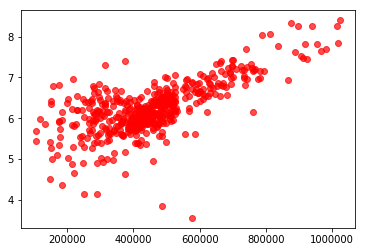

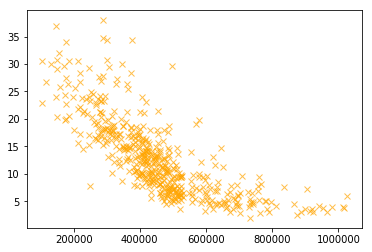

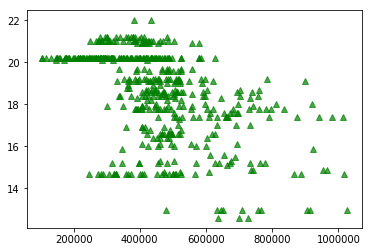

In [4]:
import matplotlib.pyplot as plt
plt.plot(prices, features['RM'], 'o', alpha=0.7,color = 'red')
plt.show()
plt.plot(prices, features['LSTAT'], 'x', alpha=0.7, color = 'orange')
plt.show()
plt.plot(prices, features['PTRATIO'], '^', alpha=0.7, color = 'green')
plt.show()

# Answer: 
## RM: 
* If the value of RM increases the value of MEDV in that neighbourhood also increases whereas lower value of RM results in lower MEDV. This is because higher number of rooms mean higher square footage and that means the house is comparitively bigger and hence the increase in price.

## LSTAT:
* If value of LSTAT increases the value of MEDV would decrease and vice versa. Since the value of LSTAT is high, this means that the area has a higher number of lower class people, which means that the neighbourhood is not that good and a bad neighbourhood is definitely going to have lower house prices.

## PTRATIO:
* A lower PTRATIO means that there are lesser number of student per one teacher in agiven neighbourhood. Generally such a trend is seen in rich neighbourhoods where there are more private schools and where the number of students in a school are less so that the teachers can better mentor each student. Thus lower PTRATIO means high MEDV and higher PTRATIO means low MEDV 

----

## Developing a Model
In this second section of the project, we will develop the tools and techniques necessary for a model to make a prediction. Being able to make accurate evaluations of each model's performance through the use of these tools and techniques helps to greatly reinforce the confidence in our predictions.

### Implementation: Define a Performance Metric
It is difficult to measure the quality of a given model without quantifying its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement. For this project, we will be calculating the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, to quantify your model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable**. A model with an R<sup>2</sup> of 0 is no better than a model that always predicts the *mean* of the target variable, whereas a model with an R<sup>2</sup> of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**. _A model can be given a negative R<sup>2</sup> as well, which indicates that the model is **arbitrarily worse** than one that always predicts the mean of the target variable._


In [5]:
# TODO: Import 'r2_score'

from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

###  Goodness of Fit
Assume that a dataset contains five data points and a model made the following predictions for the target variable:

| True Value | Prediction |
| :-------------: | :--------: |
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |

Run the code cell below to use the `performance_metric` function and calculate this model's coefficient of determination.

In [6]:
# Calculate the performance of this model
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print("Model has a coefficient of determination, R^2, of {:.3f}.".format(score))

Model has a coefficient of determination, R^2, of 0.923.


** This generates the following questions: **
* Would you consider this model to have successfully captured the variation of the target variable? 
* Why or why not?

** We should bear in mind the following points while answering the above questions. **

*  The R2 score is the proportion of the variance in the dependent variable that is predictable from the independent variable. In other words:
    * R2 score of 0 means that the dependent variable cannot be predicted from the independent variable.
    * R2 score of 1 means the dependent variable can be predicted from the independent variable.
    * R2 score between 0 and 1 indicates the extent to which the dependent variable is predictable. An 
    * R2 score of 0.40 means that 40 percent of the variance in Y is predictable from X.

**Answer:* Yes I would consider the model to have successfully captured the variation of the target variable because the R2 score of 0.923 which is very close to 1 indicates that the dependent variable can be predicted from the independent variable with a very high likelihood.*

### Implementation: Shuffle and Split Data
Our next implementation requires that you take the Boston housing dataset and split the data into training and testing subsets. Typically, the data is also shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.


In [7]:
# TODO: Import 'train_test_split'
from sklearn.model_selection import train_test_split

# TODO: Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state=42)

# Success
print("Training and testing split was successful.")

Training and testing split was successful.


### Training and Testing

* What is the benefit to splitting a dataset into some ratio of training and testing subsets for a learning algorithm?


**Answer: * As seen above we split the data in such a way that the training set has 80% of the data and testing set has 20% of the data. This makes sense because as we will train the parameters and hyper parameters of our model on the higher bulk of data which ensures that our model generalizes well, which is to say that it neither underfits nor overfits. Finally after training our model we test that model on the 20% of the data that was perviously hidden to training to make sure that our model has indeed generalized well.*

----

## Analyzing Model Performance
In this third section of the project, we'll take a look at several models' learning and testing performances on various subsets of training data. Additionally, you'll investigate one particular algorithm with an increasing `'max_depth'` parameter on the full training set to observe how model complexity affects performance. Graphing your model's performance based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.

### Learning Curves
The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R<sup>2</sup>, the coefficient of determination.  

Run the code cell below and use these graphs to answer the following question.

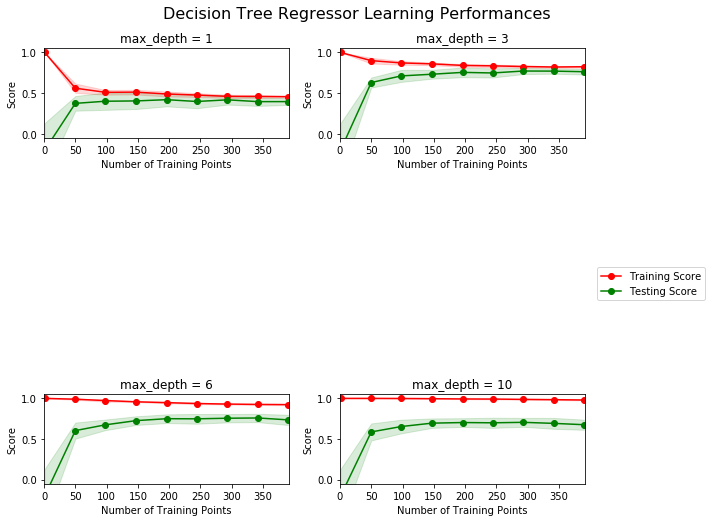

In [8]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

### Learning the Data
* We will try to analyze one of the graphs above and state the maximum depth for the model. 
* What happens to the score of the training curve as more training points are added? What about the testing curve? 
* Would having more training points benefit the model? 

**Hint:** Are the learning curves converging to particular scores? Generally speaking, the more data you have, the better. But if your training and testing curves are converging with a score above your benchmark threshold, would this be necessary?
Think about the pros and cons of adding more training points based on if the training and testing curves are converging.

**Answer: 
 *  The graph chosen by me is the one with max_depth = 10
 *  As shown in the graph initially when there are less data points the testing score is very less and the training score is very high. As more and more data points are added the training score remains 1 where as testing score increases and becomes constant at some point. This suggests that when we have a maximum depth of 10 for a model, then we are actually overfitting the data, i.e the model with max_depth = 10 has a high variance.
 *  Also as shown in the graph adding more than 150 data points is not going to do us much good as the testing score remains almost constant after that and this suggests that our model has reached its limit. Thus in order to save our resources we should stop adding data points for this model after certain level of testing score is achieved.

### Complexity Curves
The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.  


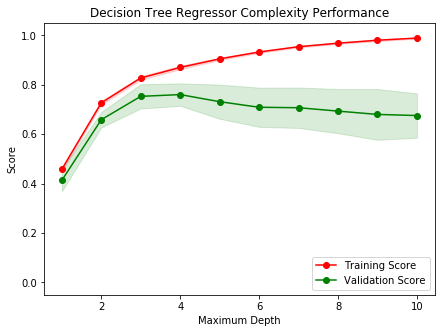

In [21]:
vs.ModelComplexity(X_train, y_train)

###  Bias-Variance Tradeoff
* When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? 
* How about when the model is trained with a maximum depth of 10? What visual cues in the graph justify your conclusions?



**Answer: 
 * When model is trained at max_depth 1 the model suffers from high bias, that is the model is underfitting the data.
 * When it is trained at max_depth 10 the model suffers from high variance. As we can see from the graph, at max_depth 10 the training score is very high(almost 1) which suggests that the model perfectly classifies all the training data, however the validation score is less, infact after max_depth = 4, the validation scores decreases continuously with increasing depths which suggests that our model with max_depth = 10 has overfitted the data and does not generalize well and it is due to this that training score is very high and validation score is very low.

### Best-Guess Optimal Model
* Which maximum depth do we think results in a model that best generalizes to unseen data? 
* What intuition lead you to this answer?

** Hint: ** Look at the graph above Question 5 and see where the validation scores lie for the various depths that have been assigned to the model. Does it get better with increased depth? At what point do we get our best validation score without overcomplicating our model? And remember, Occams Razor states "Among competing hypotheses, the one with the fewest assumptions should be selected."

**Answer: 
 * Max_depth of 4 best generalizes the model to unseen data.
 * The reason for this is that, if we look at the graph above, the validation scores for max_depth < 4 and max_depth > 4 are less than the validation score of max_depth = 4. Thus even though the training score of max_depth = 4 is less than other depths, this max_depth = 4 has the highest validation score and it is the score on unseen data which we are interested in as it gives us the best information about the generalization of the model.

-----

## Evaluating Model Performance
In this final section of the project, we will construct a model and make a prediction on the client's feature set using an optimized model from `fit_model`.

### Grid Search



 * A grid search technique is used to select the best hyper parameters of a model.
 * When we are working with an SVM model with 'rbf' kernel, when gamma and C are zero , the SVM model gives us a linear separating boundry which separates clusters of two data points so as to classify them correctly. So basically the SVM algorithm gives us weights for every feature so as to form that seperating linear boundry and these weights are the parameters of the SVM algorithm. The best of these parameters can be selected through cross-validation. However at times the data is not linearly separable and we need a more complex boundry than a linear one. These circumstances are tackled by varying the values of gamma and C. These gamma and C are the hyper-parameters of the SVM model. Now checking which of these hyper parameters are the best at separating the data is bit of a tedious task and this task is taken care of by the grid-search method.So consider that we are interested in 4 unique values of gamma and 4 unique values of C and we want to select from these 8 values which combination of gamma and C would best generalize on unseen data. The grid-search technique comes in here and what it does is create a gird of 4 X 4 (16 values) combination of all of the gamma and C and for each of those combination it will perform the cross validation technique to select the parameters or weights of the SVM model. Finally in the end from all of the 16 models, whichever model has the highest score is selected. Thus instead of selecting random values of gamma and C, we used grid search to find the best values of hyper parameters along with choosing the best value of parameters for an SVM model and in a sense optimized our model by selecting the model that has the score. This general techique holds for any other learning algorithm.

###  Cross-Validation


**Answer: 
 * The k-fold cross validaion technique divides the data into k sub parts. For example if k = 5, then the data is divided in 5 parts and cross validation is done on the 5 sub parts in such a way that each of the the sub parts is used once as a validation set. At the end of it we average the results to get our final model. In k-fold cross validation we train the data k time and in the end the results are averaged.
 * The benifit that this technique provide for grid search is that, instead of using only some part of the data, we are using all of the data to train the model and this in turn generalizes our model well on unseen data.

### Implementation: Fitting a Model
Our final implementation requires that we bring everything together and train a model using the **decision tree algorithm**. To ensure that we are producing an optimized model, we will train the model using the grid search technique to optimize the `'max_depth'` parameter for the decision tree. The `'max_depth'` parameter can be thought of as how many questions the decision tree algorithm is allowed to ask about the data before making a prediction. Decision trees are part of a class of algorithms called *supervised learning algorithms*.

In addition, we will find our implementation is using `ShuffleSplit()` for an alternative form of cross-validation (see the `'cv_sets'` variable). While it is not the K-Fold cross-validation technique we described earlier, this type of cross-validation technique is just as useful!. The `ShuffleSplit()` implementation below will create 10 (`'n_splits'`) shuffled sets, and for each shuffle, 20% (`'test_size'`) of the data will be used as the *validation set*. While you're working on your implementation, think about the contrasts and similarities it has to the K-fold cross-validation technique.

Please note that ShuffleSplit has different parameters in scikit-learn versions 0.17 and 0.18.
For the `fit_model` function in the code cell below, you will need to implement the following:
- Use [`DecisionTreeRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) from `sklearn.tree` to create a decision tree regressor object.
  - Assign this object to the `'regressor'` variable.
- Create a dictionary for `'max_depth'` with the values from 1 to 10, and assign this to the `'params'` variable.
- Use [`make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) from `sklearn.metrics` to create a scoring function object.
  - Pass the `performance_metric` function as a parameter to the object.
  - Assign this scoring function to the `'scoring_fnc'` variable.
- Use [`GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) from `sklearn.grid_search` to create a grid search object.
  - Pass the variables `'regressor'`, `'params'`, `'scoring_fnc'`, and `'cv_sets'` as parameters to the object. 
  - Assign the `GridSearchCV` object to the `'grid'` variable.

In [9]:
# TODO: Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.tree import DecisionTreeRegressor 
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # sklearn version 0.18: ShuffleSplit(n_splits=10, test_size=0.1, train_size=None, random_state=None)
    # sklearn versiin 0.17: ShuffleSplit(n, n_iter=10, test_size=0.1, train_size=None, random_state=None)
    #cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0)



    # TODO: Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # TODO: Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':[1,2,3,4,5,6,7,8,9,10]}

    
    # TODO: Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(r2_score)

    # TODO: Create the grid search cv object --> GridSearchCV()
    # Make sure to include the right parameters in the object:
    # (estimator, param_grid, scoring, cv) which have values 'regressor', 'params', 'scoring_fnc', and 'cv_sets' respectively.
    grid = GridSearchCV(regressor,params,scoring_fnc,cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

### Making Predictions
Once a model has been trained on a given set of data, it can now be used to make predictions on new sets of input data. In the case of a *decision tree regressor*, the model has learned *what the best questions to ask about the input data are*, and can respond with a prediction for the **target variable**. You can use these predictions to gain information about data where the value of the target variable is unknown — such as data the model was not trained on.

###  Optimal Model

* What maximum depth does the optimal model have? How does this result compare to our guess ?  


In [11]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

Parameter 'max_depth' is 4 for the optimal model.




**Answer: 
 * The optimal max_depth is 4 and it is exactly the same as in Question 6

### Predicting Selling Prices
Imagine that you were a real estate agent in the Boston area looking to use this model to help price homes owned by your clients that they wish to sell. You have collected the following information from three of your clients:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |

* What price would you recommend each client sell his/her home at? 
* Do these prices seem reasonable given the values for the respective features? 

**Hint:** We will use the statistics calculated in the **Data Exploration** section to help justify our response.  Of the three clients, client 3 has has the biggest house, in the best public school neighborhood with the lowest poverty level; while client 2 has the smallest house, in a neighborhood with a relatively high poverty rate and not the best public schools.


In [12]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print("Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price))

Predicted selling price for Client 1's home: $403,025.00
Predicted selling price for Client 2's home: $237,478.72
Predicted selling price for Client 3's home: $931,636.36


**Answer: 
 * 
   ** Predicted selling price for Client 1's home: $403,025.00
   
   ** Predicted selling price for Client 2's home: $237,478.72
   
   ** Predicted selling price for Client 3's home: $931,636.36
  
 * Yes these price seem reasonable, because as stated above, Client1's home has 5 bedrooms and is in a reasonable neighbourhood and the poverty percentage is not that high, also the schools in that neighbourhood seem reasonable and hence the price of that house is in the mid-ranges. Also Client 2's is the smallest of the homes, is in an area of high poverty and the ratio of students to teachers is also very high, all in all this house does not seem to be in a good neighbourhood, it is small and hence it has the lowest price of all. Client 3's home is the biggest of all has a very less population of poor people around it and has good schools as seen from the student teacher ratio and hence its high price is justifiable.
   

### Sensitivity
An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted. 

**Run the code cell below to run the `fit_model` function ten times with different training and testing sets to see how the prediction for a specific client changes with respect to the data it's trained on.**

In [25]:
vs.PredictTrials(features, prices, fit_model, client_data)

Trial 1: $391,183.33
Trial 2: $419,700.00
Trial 3: $415,800.00
Trial 4: $420,622.22
Trial 5: $418,377.27
Trial 6: $411,931.58
Trial 7: $399,663.16
Trial 8: $407,232.00
Trial 9: $351,577.61
Trial 10: $413,700.00

Range in prices: $69,044.61


###  Applicability



 * The data was collected in 1978. It is not reasonable to use a model trained on a 40 year old data. This is because in 40 years there may have been a lot of changes in lot of neighbourhoods. For example. a bad neighbourhood may have become good through gentrification, and vice versa. In such a circumstance this particular model would predict wrong prices for the houses. We also have to take into consideration the inflation, the house prices would have increased consistently in 40 years and hence such a model would seriously undervalue a client's home if the prediction is made today.
 * The features are also limited. What is a person has a small house in a very large area, what if the house is small but is extremly hitech. In such circumstances the house of the price would be much higher that the price predicted by the model.
 * The model also is not good enough to make consistent predictions which is visible from the above codeblock. The reason being, the data is insufficient and is not representative of the entire population data.
 * The data collected was in Boston. Now not all the cities have same price of real estate. Metropolitans like Boston New york etc have a very high price for small houses whereas the same house size may cost substantially less in other smaller cities. Hence this model can be used only on Boston and no-where else.
 * It is also not fair to judge the price of the house on the basis of the neighbourhood. It may happen sometimes that a very good house is built in a bad neighbourhood and vice-versa. Under such circumstances the model may make some serious mistakes in valuing the prize of the house.